# XGBoost Model and Comparison

## Imports

In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
import joblib

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from src.__00__paths import curated_data_dir, model_dir, figures_dir, docs_dir

## Load Data

In [2]:
train_df = pd.read_csv(curated_data_dir / "train.csv")
train_df.head()

,Type_A,Type_B,Type_C,Size,Dept,IsHoliday,time_index,woy_sin,woy_cos,mon_sin,...,dist_easter_wk,dist_memorial_day_wk,dist_july4_wk,dist_labor_day_wk,dist_super_bowl_wk,is_black_friday_wk,is_thanksgiving_wk,is_xmas_peak_wk,is_back_to_school,Weekly_Sales
0,True,False,False,151315,1,False,0,0.566372,0.82415,0.866025,...,0,0,0,0,-1,1,1,1,0,24924.50
1,False,True,False,125833,97,False,0,0.566372,0.82415,0.866025,...,0,0,0,0,-1,1,1,1,0,668.48
2,False,True,False,125833,85,False,0,0.566372,0.82415,0.866025,...,0,0,0,0,-1,1,1,1,0,693.87
3,True,False,False,155078,80,False,0,0.566372,0.82415,0.866025,...,0,0,0,0,-1,1,1,1,0,8654.60
4,False,True,False,125833,55,False,0,0.566372,0.82415,0.866025,...,0,0,0,0,-1,1,1,1,0,11123.56


In [3]:
test_df = pd.read_csv(curated_data_dir / "test.csv")
test_df.head()

,Type_A,Type_B,Type_C,Size,Dept,IsHoliday,time_index,woy_sin,woy_cos,mon_sin,...,dist_easter_wk,dist_memorial_day_wk,dist_july4_wk,dist_labor_day_wk,dist_super_bowl_wk,is_black_friday_wk,is_thanksgiving_wk,is_xmas_peak_wk,is_back_to_school,Weekly_Sales
0,False,True,False,125833,17,False,115,0.937328,-0.348448,0.866025,...,1,-6,0,0,0,1,1,1,0,4202.98
1,True,False,False,184109,41,False,115,0.937328,-0.348448,0.866025,...,1,-6,0,0,0,1,1,1,0,307.50
2,True,False,False,203750,3,False,115,0.937328,-0.348448,0.866025,...,1,-6,0,0,0,1,1,1,0,7245.43
3,False,False,True,39910,23,False,115,0.937328,-0.348448,0.866025,...,1,-6,0,0,0,1,1,1,0,23.01
4,False,True,False,140167,4,False,115,0.937328,-0.348448,0.866025,...,1,-6,0,0,0,1,1,1,0,19455.41


In [4]:
x_train = train_df.drop(["Weekly_Sales"], axis=1)
x_test = test_df.drop(["Weekly_Sales"], axis=1)
y_train = train_df["Weekly_Sales"]
y_test = test_df["Weekly_Sales"]

## Train XGBoost Model

In [5]:
xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_jobs=-1,
    random_state=42,
    verbosity=0,
    n_estimators=170,
    max_depth=38,
    learning_rate=0.1,
    colsample_bytree=0.3,
    min_child_weight=1,
    gamma=0,
    subsample=1
)

xgb_model.fit(x_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.3, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=0, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=38,
             max_leaves=None, min_child_weight=1, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=170,
             n_jobs=-1, num_parallel_tree=None, ...)

## Save Model

In [6]:
joblib.dump(xgb_model, model_dir / "xgboost_model.joblib")
print(f"XGBoost model saved at {'/'.join(model_dir.parts[-3:])}")

XGBoost model saved at SmartRetailRegressor/outputs/models


## Top 20 Features

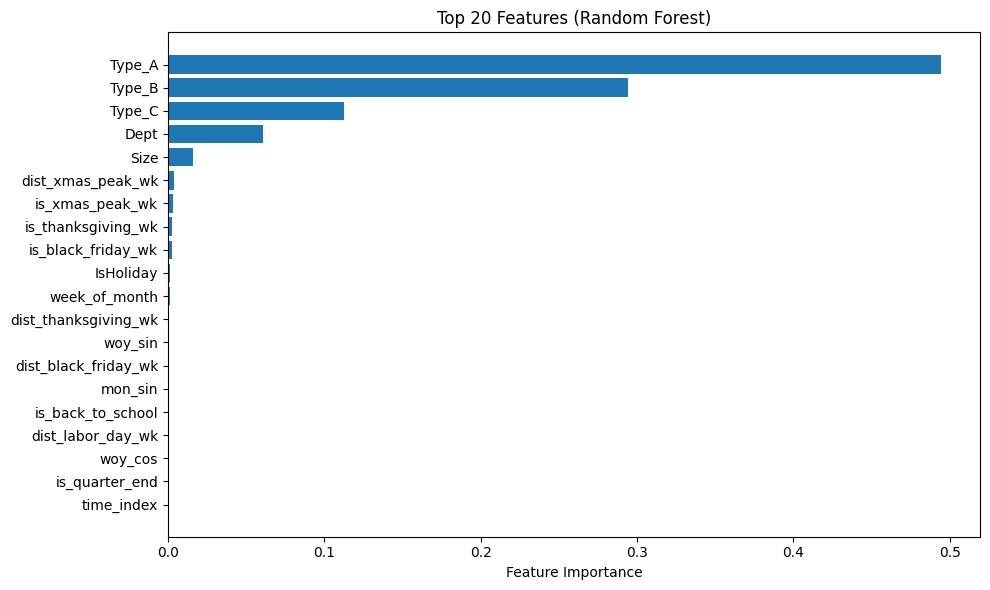

In [7]:
importances = xgb_model.feature_importances_
features = x_train.columns
indices = np.argsort(importances)[::-1][:20]

plt.figure(figsize=(10, 6))
plt.barh(range(len(indices)), importances[indices][::-1])
plt.yticks(range(len(indices)), features[indices][::-1])
plt.xlabel("Feature Importance")
plt.title("Top 20 Features (Random Forest)")
plt.tight_layout()

# Save the figure before showing it
plt.savefig(figures_dir / "XGBoost_feature_importance.png", dpi=300)

plt.show()

## Evaluate XGBoost Model


In [8]:
y_pred_xgb = xgb_model.predict(x_test)

mae = mean_absolute_error(y_test, y_pred_xgb)
avg_sales = y_test.mean()
relative_error = mae / avg_sales * 100

weights = test_df["IsHoliday"].apply(lambda x: 5 if x else 1)
wmae = (weights * abs(y_test - y_pred_xgb)).sum() / weights.sum()

rmse = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
r2 = r2_score(y_test, y_pred_xgb) * 100

# Print results
print(f"MAE: {mae:.2f}")
print(f"Average Weekly Sales: ${avg_sales:.2f}")
print(f"Relative MAE: {relative_error:.2f}%")
print(f"WMAE: {wmae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R² Score: {r2:.2f}%")

MAE: 2974.37
Average Weekly Sales: $15785.37
Relative MAE: 18.84%
WMAE: 3018.83
RMSE: 4906.47
R² Score: 95.01%


## Save Text File

In [9]:
# File path for metrics
metrics_file = docs_dir / "XGBoost_model_metrics.txt"

# Write metrics
with open(metrics_file, "w") as f:
    f.write(f"MAE: {mae:.2f}\n")
    f.write(f"Average Weekly Sales: ${avg_sales:.2f}\n")
    f.write(f"Relative MAE: {relative_error:.2f}%\n")
    f.write(f"WMAE: {wmae:.2f}\n")
    f.write(f"RMSE: {rmse:.2f}\n")
    f.write(f"R² Score: {r2:.4f}\n")

print(f"Evaluation metrics saved to: {'/'.join(metrics_file.parts[-3:])}")

Evaluation metrics saved to: outputs/docs/XGBoost_model_metrics.txt


## Visualization

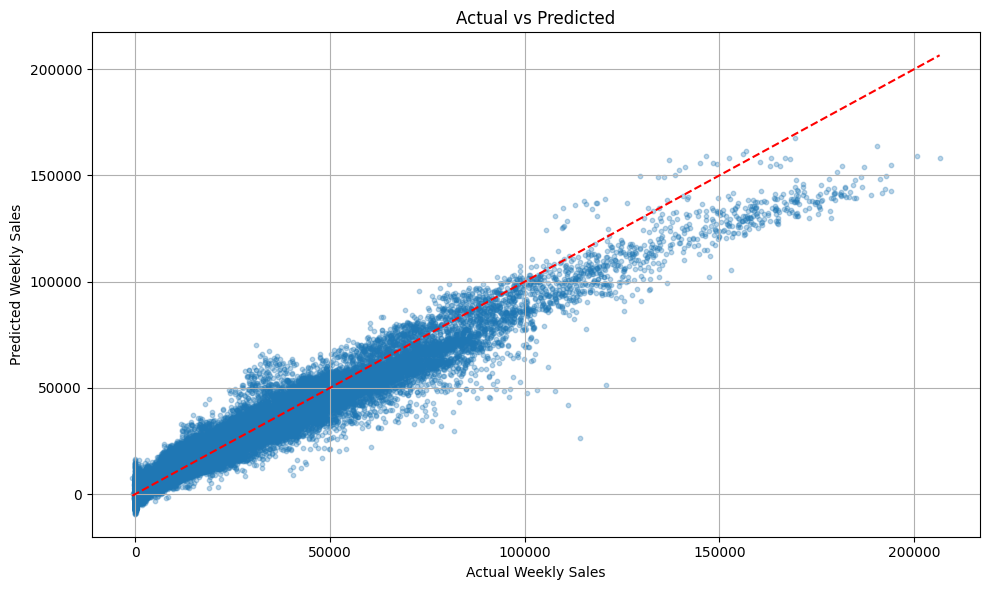

In [10]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_xgb, alpha=0.3, s=10)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Weekly Sales")
plt.ylabel("Predicted Weekly Sales")
plt.title("Actual vs Predicted")
plt.grid(True)
plt.tight_layout()

# Save the figure before showing it
plt.savefig(figures_dir / "XGBoost_actual_predicted.png", dpi=300)

plt.show()

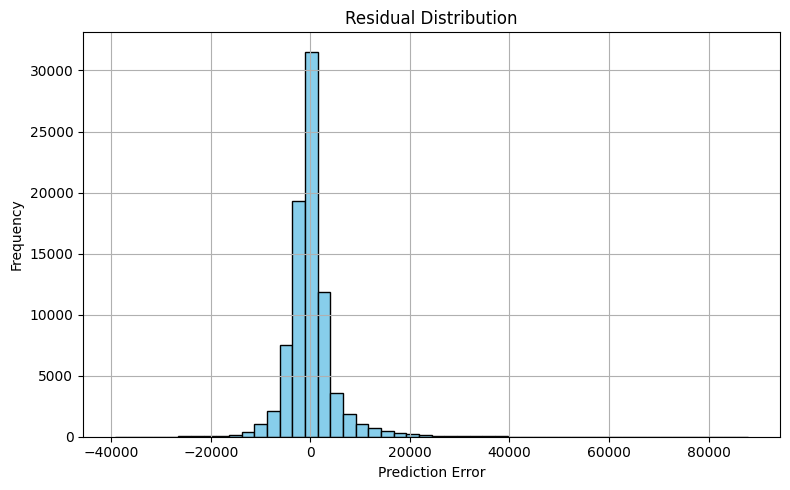

In [11]:
residuals = y_test - y_pred_xgb
plt.figure(figsize=(8, 5))
plt.hist(residuals, bins=50, color="skyblue", edgecolor="black")
plt.title("Residual Distribution")
plt.xlabel("Prediction Error")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.savefig(figures_dir / "XGBoost_residual_hist.png", dpi=300)
plt.show()

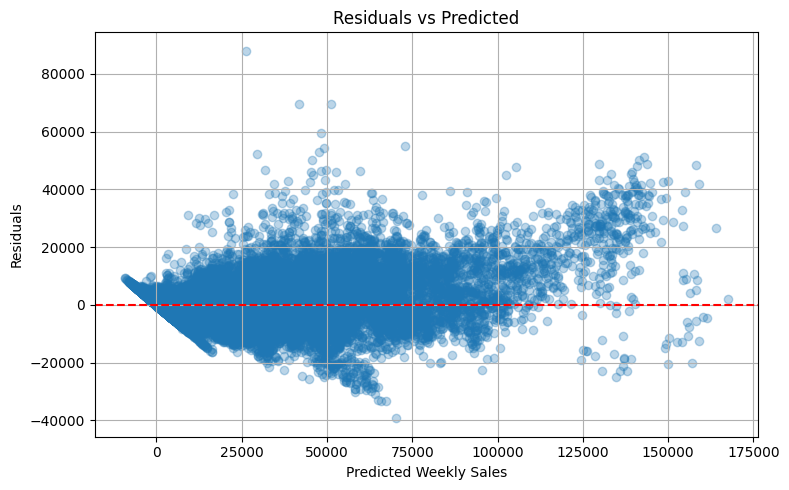

In [12]:
plt.figure(figsize=(8, 5))
plt.scatter(y_pred_xgb, residuals, alpha=0.3)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Weekly Sales")
plt.ylabel("Residuals")
plt.title("Residuals vs Predicted")
plt.grid(True)
plt.tight_layout()
plt.savefig(figures_dir / "XGBoost_residuals_vs_pred.png", dpi=300)
plt.show()